In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import esda as es
import json
import libpysal as ps
from esda.moran import Moran
import geopandas as gpd
from shapely.geometry import Point

## Load data

In [91]:
plt.style.use('ggplot')
# load the feature category dictionary
with open('feature_category_dict.json') as f:
	fcmap = json.load(f)

data=pd.read_csv('combined_data_with_loc.csv')
data.head()

,Community Name,Region,Map reference,Grid reference,Location,Population Density,Travel time to GPO (minutes),Distance to GPO (km),LGA,Primary Care Partnership,...,Travel time to nearest public hospital with emergency department,Distance to nearest public hospital with emergency department,Presentations to emergency departments due to injury,"Presentations to emergency departments due to injury, %",Category 4 & 5 emergency department presentations,"Category 4 & 5 emergency department presentations, %",geo_lat,geo_lon,cart_x,cart_y
0,Ascot Vale,Northern and Western Metropolitan,4,B3,6km NW of Melbourne,3758.623596,9.360142,6.958742,Moonee Valley (C),Inner North West Primary Care Partnership,...,6.630953,4.993841,679.257076,20.502456,1864.918123,56.290032,-37.775606,144.914871,-4.230377,4.251470
1,Braybrook,Northern and Western Metropolitan,4,A3,10km WNW of Melbourne,2025.468296,15.131666,11.595888,Maribyrnong (C),"HealthWest (b): Hobson's Bay, Maribyrnong, Wyn...",...,12.824977,10.161988,543.631989,20.647263,1683.966712,63.957428,-37.779315,144.858155,-9.212552,3.839001
2,Craigieburn,Northern and Western Metropolitan,2,A3,27km N of Melbourne,1034.970870,31.994666,43.100287,Hume (C),Hume-Whittlesea Primary Care Partnership,...,11.570855,15.213189,2044.424399,20.618005,5102.134434,51.454988,-37.570576,144.963028,0.000000,27.049690
3,Croydon,Eastern Metropolitan,2,B4,28km E of Melbourne,1730.064830,28.992647,34.071323,Maroondah (C),Outer East Primary Care Partnership,...,5.093285,3.601752,1754.954941,28.537825,3062.182462,49.795026,-37.813411,145.281013,27.933349,0.047723
4,Fawkner,Northern and Western Metropolitan,4,C1,12km N of Melbourne,2619.120089,17.405267,13.047142,Moreland (C),Inner North West Primary Care Partnership,...,11.510757,12.004044,680.401318,17.909865,1942.874353,51.141315,-37.705724,144.963028,0.000000,12.021947


## Visualize Suburbs

$(x,y)$ locations based on the compass bearing and the distance from Melbourne GPO, with GPO co-ordinate as $(0,0)$

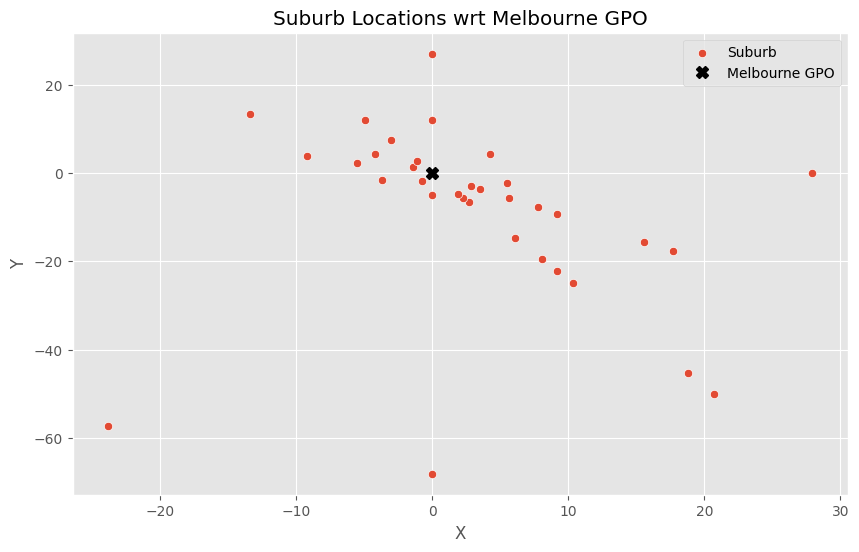

In [92]:
# plot boxes around the points
plt.figure(figsize=(10, 6))
sns.scatterplot(x='cart_x', y='cart_y', data=data)
plt.xlabel('X')
plt.ylabel('Y')
# show origin
plt.plot(0, 0, 'X', markersize=9, color='black')
plt.legend(['Suburb', 'Melbourne GPO'])
plt.title('Suburb Locations wrt Melbourne GPO')
plt.show()

## Avg distances of the neighbouring suburbs

In [93]:
from sklearn.neighbors import NearestNeighbors
import scipy.stats as stats

class nnStats:
	def __init__(self, n_nbd):
		self.n_nbd=n_nbd
	def get_dist_mean(self):
		nn=NearestNeighbors(n_neighbors=self.n_nbd,metric='euclidean')
		nn.fit(data[['cart_x', 'cart_y']])
		distances, indices = nn.kneighbors(data[['cart_x', 'cart_y']])
		self.avg_dist=float(np.mean(distances[:, -1]))
		self.median_dist=float(np.median(distances[:, -1]))
		distances = distances[:, 1:].mean(axis=1)
		return distances
	
	def get_plot_avg_dist(self):
		dist=self.get_dist_mean()
		plt.figure(figsize=(5, 5))
		sns.displot(dist, kde=True)
		plt.axvline(self.avg_dist, color='red', linestyle='--', label='Mean distance')
		plt.axvline(self.median_dist, color='blue', linestyle='--', label='Median distance')
		plt.xlabel('Distance')
		plt.ylabel('Frequency')
		plt.title(f'Average distance of all the neighbours up to: {self.n_nbd}')
		plt.legend()
		plt.show()
		return None
    

In [94]:
for i in range(2, 6):
	dist_details=nnStats(i)
	dist_details.get_dist_mean()
	print(f'(Avg, Median) distances of all the neighbours up to {i}: {(dist_details.avg_dist, dist_details.median_dist)}')

(Avg, Median) distances of all the neighbours up to 2: (5.245844868152378, 3.002145038830941)
(Avg, Median) distances of all the neighbours up to 3: (8.212108297752518, 5.000021947800075)
(Avg, Median) distances of all the neighbours up to 4: (9.474117173901222, 6.196951246827995)
(Avg, Median) distances of all the neighbours up to 5: (10.573740404368039, 7.138554022936674)


<Figure size 500x500 with 0 Axes>

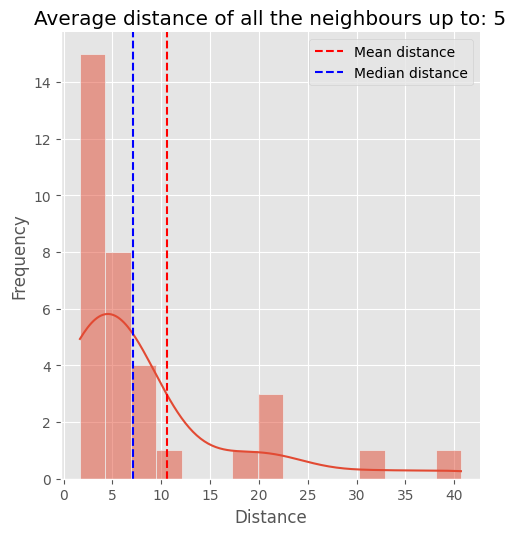

In [95]:
dist_details.get_plot_avg_dist()

## Test out autocorrelation for an example feature

Let's test `Population Density`

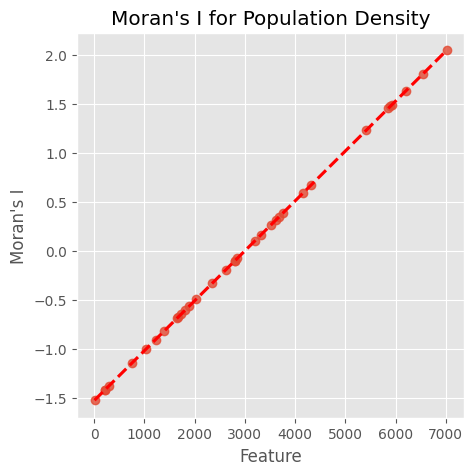

Moran's I: 0.6716484992594537
Moran's Expected I: -0.030303030303030304
Moran's I p-value: 0.001


In [96]:
from geopandas import GeoDataFrame
# choose k=4
k=4

# select the feature
feature='Population Density'

gdf=gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['cart_x'], data['cart_y']))

# create a spatial weights matrix
w=ps.weights.KNN.from_dataframe(gdf, k=k)

# create a Moran object
moran=Moran(data[feature], w)

# plot the Moran scatter plot
plt.figure(figsize=(5, 5))
sns.regplot(x=data[feature], y=moran.z, line_kws={'color':'red', 'linestyle':'--'})
plt.xlabel('Feature')
plt.ylabel('Moran\'s I')
plt.title(f'Moran\'s I for {feature}')
plt.show()

print('Moran\'s I:', moran.I)
print('Moran\'s Expected I:', moran.EI)
print('Moran\'s I p-value:', moran.p_sim)


In [97]:
def get_moran(feature, k):
	# select the feature
	feature='Population Density'

	gdf=gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['cart_x'], data['cart_y']))

	# create a spatial weights matrix
	w=ps.weights.KNN.from_dataframe(gdf, k=k)

	# create a Moran object
	moran=Moran(data[feature], w, permutations=9999)

	print('Moran\'s I:', moran.I)
	print('Moran\'s Expected I:', moran.EI)
	print('Moran\'s I p-value:', moran.p_sim)

	return None

for i in range(2, 6):
	print(f'For k={i}')
	get_moran('Population Density', i)


For k=2
Moran's I: 0.7345791369817825
Moran's Expected I: -0.030303030303030304
Moran's I p-value: 0.0001
For k=3
Moran's I: 0.6661154765400408
Moran's Expected I: -0.030303030303030304
Moran's I p-value: 0.0001
For k=4
Moran's I: 0.6716484992594537
Moran's Expected I: -0.030303030303030304
Moran's I p-value: 0.0001
For k=5
Moran's I: 0.623149176456302
Moran's Expected I: -0.030303030303030304
Moran's I p-value: 0.0001


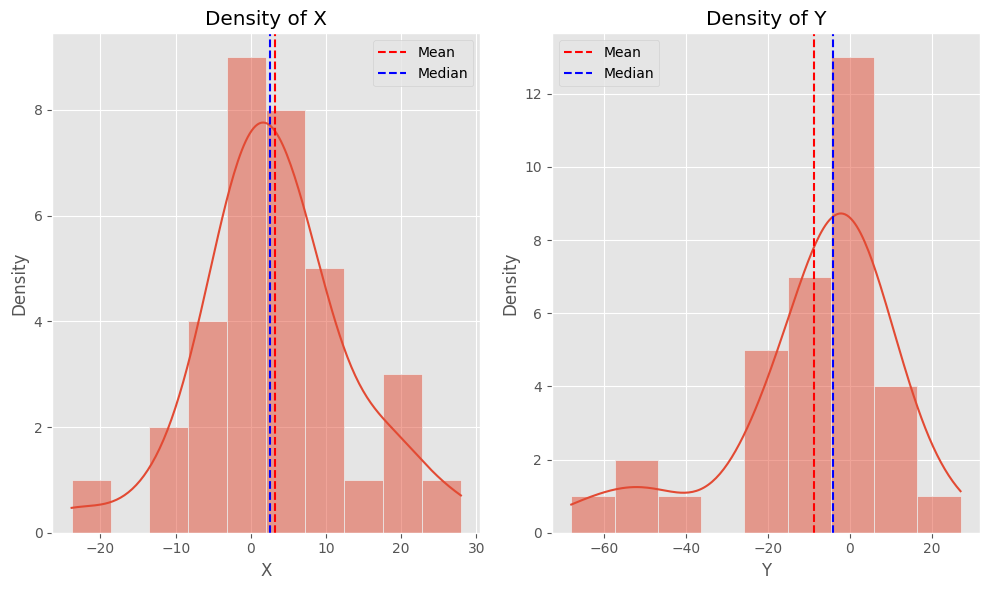

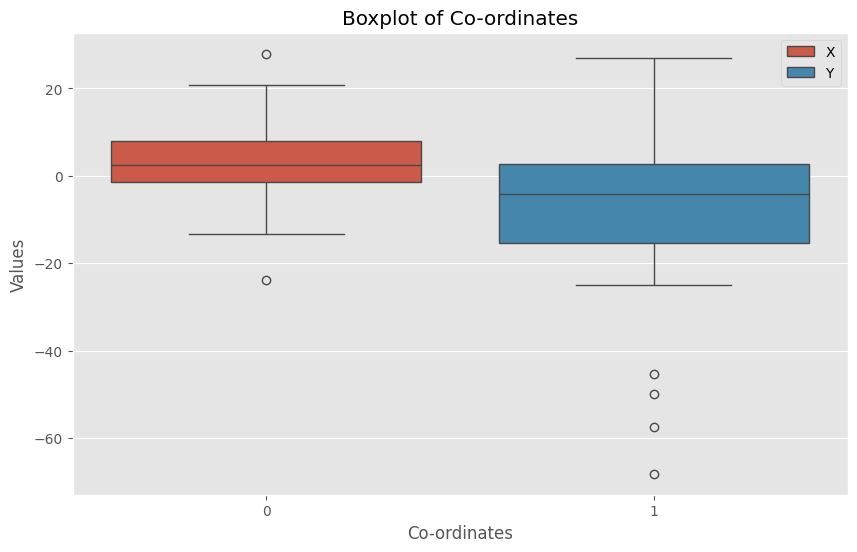

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data' is your DataFrame with 'cart_x' and 'cart_y' columns

plt.figure(figsize=(10, 6))

# Subplot 1: Density of X
plt.subplot(1, 2, 1)
sns.histplot(data['cart_x'], kde=True)
plt.xlabel('X')
plt.ylabel('Density')
plt.title('Density of X')
# plot mean and median of X
plt.axvline(data['cart_x'].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(data['cart_x'].median(), color='blue', linestyle='--', label='Median')
# show legend
plt.legend()

# Subplot 2: Density of Y
plt.subplot(1, 2, 2)
sns.histplot(data['cart_y'], kde=True)
plt.xlabel('Y')
plt.ylabel('Density')
plt.title('Density of Y')
# plot mean and median of Y
plt.axvline(data['cart_y'].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(data['cart_y'].median(), color='blue', linestyle='--', label='Median')
# show legend
plt.legend()



# Adjust layout for better spacing
plt.tight_layout()
plt.show()


# boxplot of the co-ordinates
suburb_locs=zip(data['cart_x'], data['cart_y'])
suburb_locs=list(suburb_locs)
suburb_locs=np.array(suburb_locs)
plt.figure(figsize=(10, 6))
sns.boxplot(data=suburb_locs)
plt.xlabel('Co-ordinates')
plt.ylabel('Values')
plt.title('Boxplot of Co-ordinates')
plt.legend(['X', 'Y'])
plt.show()

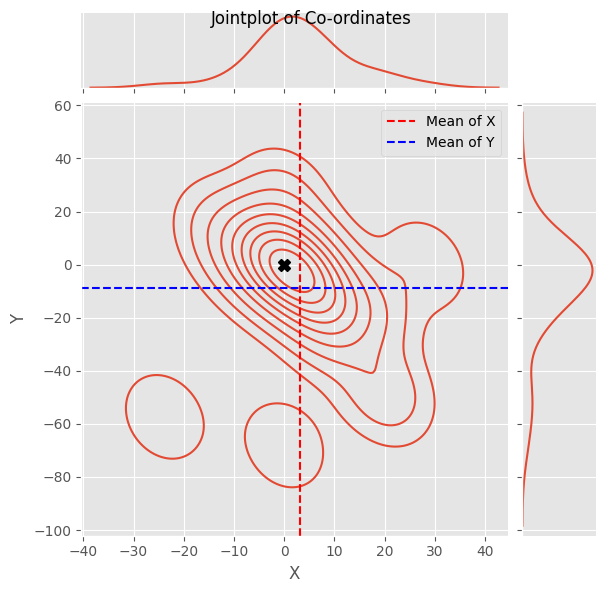

In [99]:
# jointplot of the co-ordinates
sns.jointplot(x='cart_x', y='cart_y', data=data, kind='kde')
plt.xlabel('X')
plt.ylabel('Y')
# show origin
plt.plot(0, 0, 'X', markersize=9, color='black')
plt.legend(['Melbourne GPO'])
# also show the mean of the co-ordinates
plt.axvline(data['cart_x'].mean(), color='red', linestyle='--', label='Mean of X')
plt.axhline(data['cart_y'].mean(), color='blue', linestyle='--', label='Mean of Y')
plt.legend()
plt.suptitle('Jointplot of Co-ordinates')
plt.show()

In [100]:
# let's pick the feature category 'Services'
feature_category='Services'
# get the features in the selected category
features=fcmap[feature_category]
# select the features
data_services=data[features]
data_services.head()

,Public Hospitals,Private Hospitals,Community Health Centres,Bush Nursing Centres,Allied Health,Alternative Health,Child Protection and Family,Dental,Disability,General Practice,...,Aged Care (Low Care),Aged Care (SRS),Kinder and/or Childcare,Primary Schools,Secondary Schools,P12 Schools,Other Schools,Centrelink Offices,Medicare Offices,Medicare Access Points
0,0,1,1,0,10,5,0,0,0,2,...,31,0,4,3,0,0,1,0,0,0
1,0,0,1,0,13,1,0,1,1,4,...,0,0,1,2,2,0,1,0,0,0
2,1,0,1,0,15,0,0,1,1,8,...,0,0,2,6,1,1,0,0,0,0
3,0,1,0,0,30,8,0,7,9,9,...,179,45,10,5,2,0,0,0,0,0
4,0,0,1,0,13,1,0,1,0,5,...,150,0,3,4,1,1,0,0,0,0


Correlation between the first two suburbs: PearsonRResult(statistic=np.float64(0.20389225159217567), pvalue=np.float64(0.33925866318638714))


C:\Users\subha\AppData\Local\Temp\ipykernel_15160\3367062486.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr=stats.pearsonr(data1, data2)


Filling nan values with 0


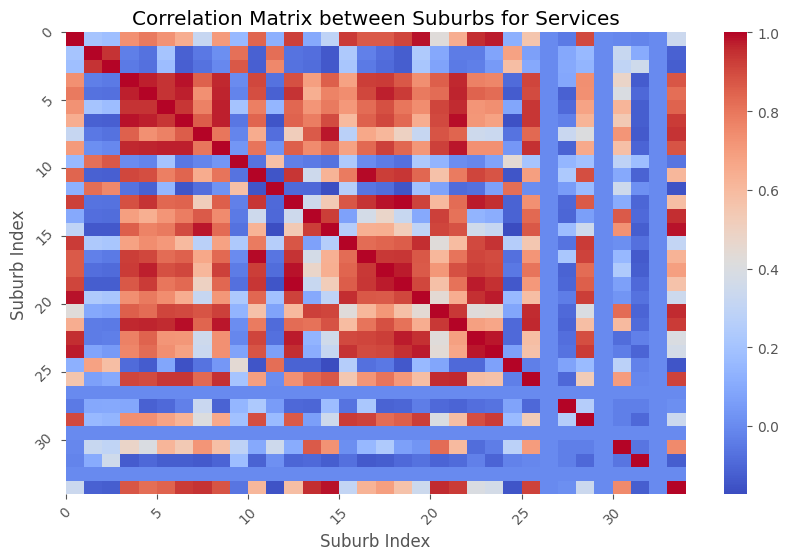

In [101]:
def compute_corr_service(sub_idx1, sub_idx2):
	# select the data
	data1=data_services.iloc[sub_idx1]
	data2=data_services.iloc[sub_idx2]
	# compute the correlation
	corr=stats.pearsonr(data1, data2)
	return corr

# compute the correlation between the first two suburbs
sub_idx1=0
sub_idx2=1
corr=compute_corr_service(sub_idx1, sub_idx2)
print(f'Correlation between the first two suburbs: {corr}')

# plot the correlation matrix between towns i, j
corr_mat=np.zeros((data_services.shape[0], data_services.shape[0]))
for i in range(data_services.shape[0]):
	for j in range(data_services.shape[0]):
		corr=compute_corr_service(i, j)
		corr_mat[i, j]=corr[0]

# fill nan values with 0
corr_mat=np.nan_to_num(corr_mat)
print('Filling nan values with 0')
plt.figure(figsize=(10, 6))
sns.heatmap(corr_mat, cmap='coolwarm')

plt.title('Correlation Matrix between Suburbs for Services')
plt.xlabel('Suburb Index')
plt.ylabel('Suburb Index')
plt.xticks(ticks=np.arange(0,data_services.shape[0],5), labels=np.arange(0,data_services.shape[0],5), rotation=45)
plt.yticks(ticks=np.arange(0,data_services.shape[0],5), labels=np.arange(0,data_services.shape[0],5), rotation=45)
plt.show()

In [102]:
# compute GWR on the correlation matrix


In [103]:
data.iloc[32]

Community Name                                                      Waterways
Region                                                  Southern Metropolitan
Map reference                                                               2
Grid reference                                                             C4
Location                                                27km SSE of Melbourne
                                                                ...          
Category 4 & 5 emergency department presentations, %                53.754108
geo_lat                                                            -38.038519
geo_lon                                                            145.080728
cart_x                                                              10.339287
cart_y                                                             -24.983131
Name: 32, Length: 230, dtype: object

In [104]:
# flatten w matrix
w_flatten=w.full()[0].flatten()
corr_flat=corr_mat.flatten()
len(corr_flat), len(w_flatten)

# find the correlation between the spatial weights and the correlation matrix
corr_w=stats.pearsonr(corr_flat, w_flatten)
print(f'Correlation between the spatial weights and the correlation matrix: {corr_w}')
# do spearman correlation
corr_w=stats.spearmanr(corr_flat, w_flatten)
print(f'Spearman Correlation between the spatial weights and the correlation matrix: {corr_w}')

Correlation between the spatial weights and the correlation matrix: PearsonRResult(statistic=np.float64(0.04243399072435882), pvalue=np.float64(0.14934630669733057))
Spearman Correlation between the spatial weights and the correlation matrix: SignificanceResult(statistic=np.float64(0.034018577878345085), pvalue=np.float64(0.2477978136226533))


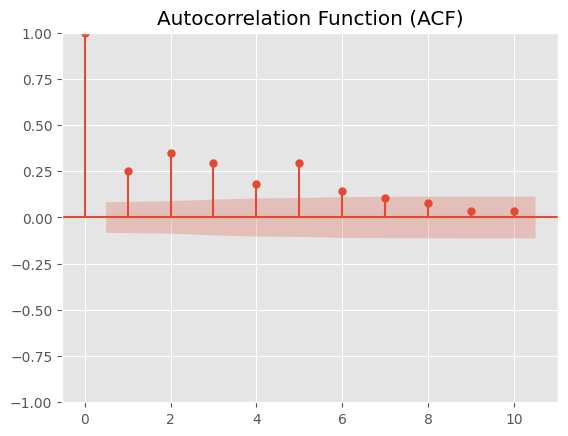

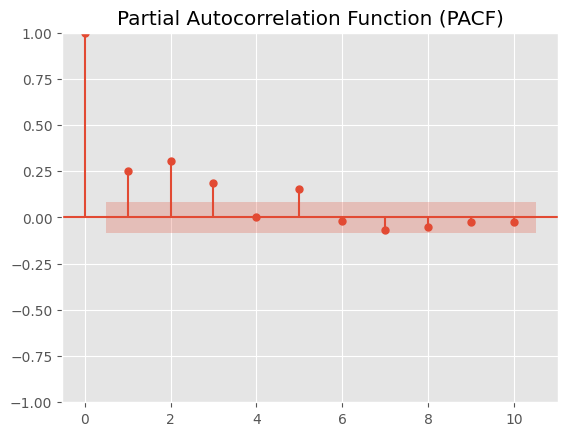

In [105]:
# compute autocorrelation for flattened correlation matrix
# (don't use moran's I as it is not suitable for this case)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Example : A univariate time series

# consider only the upper triangular part of the correlation matrix
corr_flat=corr_mat[np.triu_indices(corr_mat.shape[0], k=1)]


# ACF plot
plot_acf(corr_flat, lags=10)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# PACF plot
plot_pacf(corr_flat, lags=10)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


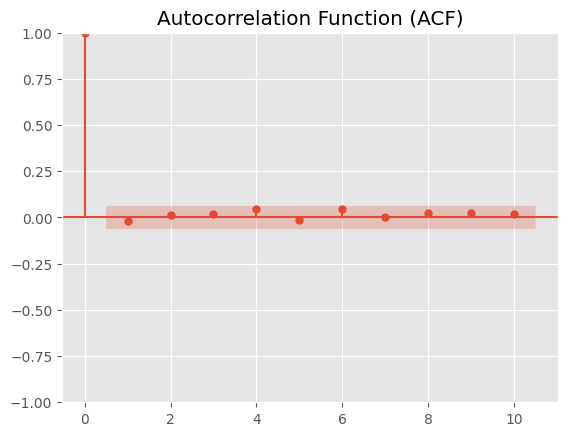

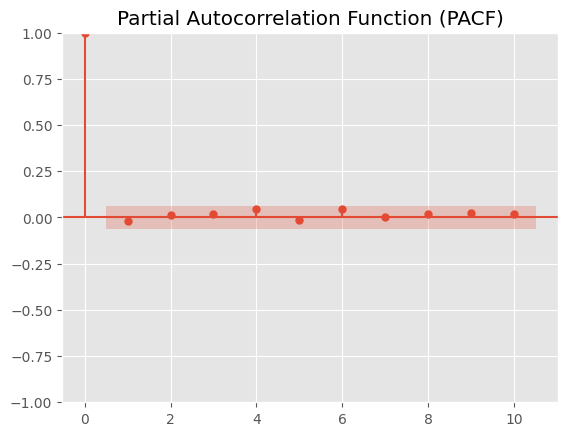

In [106]:
# compute autocorrelation for flattened correlation matrix
# (don't use moran's I as it is not suitable for this case)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Example : A univariate time series

# consider only the upper triangular part of the correlation matrix
sample_random=np.random.normal(0, 1, 1000)


# ACF plot
plot_acf(sample_random, lags=10)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# PACF plot
plot_pacf(sample_random, lags=10)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


In [107]:
X=suburb_locs
# compute geographical weight matrix, W_ij=exp(-d_ij^2)
def get_geographical_weights(X):
	n=X.shape[0]
	W=np.zeros((n, n))
	for i in range(n):
		for j in range(n):
			W[i, j]=np.exp(-np.linalg.norm(X[i]-X[j])**2)
	return W

W_geo=get_geographical_weights(X)

P=(X.T@W_geo@X)
P_inv=np.linalg.inv(P)
Q=(X.T@W_geo@corr_mat)
B=P_inv@Q
print('B:', B)

# compute R^2
R_sq=1-(np.linalg.norm(Q-P@B)**2/np.linalg.norm(Q)**2)
print('R^2:', R_sq)
# compute p-value

## compute variance of residuals
residuals=Q-P@B
var_res=np.var(residuals)
print('Variance of residuals:', var_res)

B: [[ 0.0047317  -0.00324321 -0.0025575   0.01876476  0.01669108  0.01761757
   0.02010535  0.02278729  0.01896248 -0.00222184  0.01230603 -0.00271046
   0.01052222  0.02274286  0.02332091  0.00395351  0.01248998  0.0133418
   0.01014937  0.00463216  0.02171511  0.02010144  0.00602988  0.00520629
  -0.00246934  0.02029451  0.          0.0028086   0.00560062  0.
   0.01885683  0.00077339  0.          0.0231201 ]
 [-0.00620312  0.00108712  0.00062611 -0.0061196  -0.00646016 -0.00545724
  -0.00585633 -0.0037812  -0.00587303  0.00070291 -0.00661174  0.00107652
  -0.0068082  -0.00242207 -0.00388059 -0.00575954 -0.00654168 -0.0066921
  -0.0068556  -0.00604689 -0.0040549  -0.00567904 -0.00673062 -0.00637482
   0.00103373 -0.00506912  0.          0.00025239 -0.00590122  0.
  -0.00055134 -0.00135858  0.         -0.0040908 ]]
R^2: 1.0
Variance of residuals: 2.7123576470432135e-29


Correlation between distance and correlation: PearsonRResult(statistic=np.float64(0.34013063364870844), pvalue=np.float64(1.0651612028518989e-32))


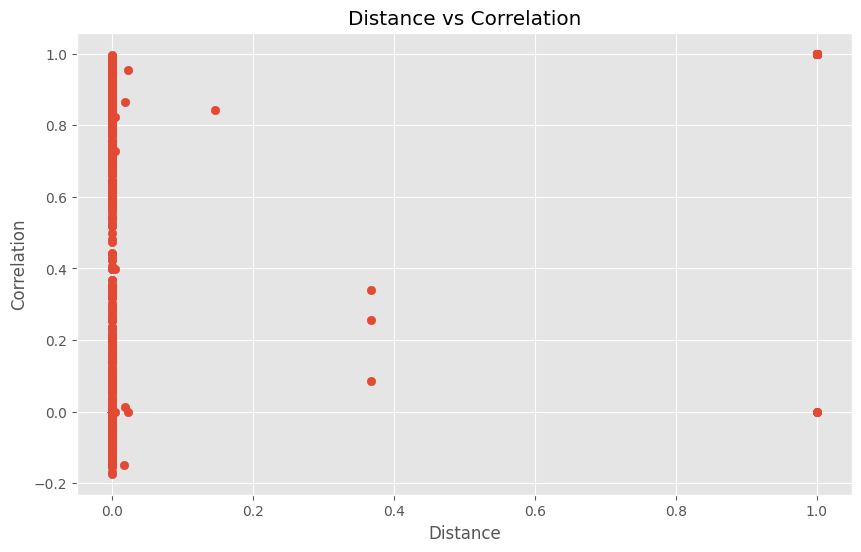

In [108]:
## Compute correlation between distance and correlation 

W_geo_flat=np.triu(W_geo).flatten()
corr_flat=np.triu(corr_mat).flatten()
corr_dist=stats.pearsonr(W_geo_flat, corr_flat)
print('Correlation between distance and correlation:', corr_dist)
# plot 
plt.figure(figsize=(10, 6))
plt.scatter(W_geo_flat, corr_flat)
plt.xlabel('Distance')
plt.ylabel('Correlation')
plt.title('Distance vs Correlation')
plt.show()


In [109]:
# compute correlation between geographical position and feature in the selected category
for i in range(data_services.shape[1]):
	corr_x=stats.pearsonr(data['cart_x'], data_services.iloc[:, i])
	corr_y=stats.pearsonr(data['cart_y'], data_services.iloc[:, i])
	print(f'Correlation between X and feature {i}: {corr_x}')
	print(f'Correlation between Y and feature {i}: {corr_y}')
	


Correlation between X and feature 0: PearsonRResult(statistic=np.float64(-0.11401135385316387), pvalue=np.float64(0.5208554707666634))
Correlation between Y and feature 0: PearsonRResult(statistic=np.float64(0.18406718665923286), pvalue=np.float64(0.297375271919306))
Correlation between X and feature 1: PearsonRResult(statistic=np.float64(0.1282386050196917), pvalue=np.float64(0.46981720571840346))
Correlation between Y and feature 1: PearsonRResult(statistic=np.float64(0.1485450224199088), pvalue=np.float64(0.40179100064632545))
Correlation between X and feature 2: PearsonRResult(statistic=np.float64(-0.21631602188930324), pvalue=np.float64(0.21916141552826504))
Correlation between Y and feature 2: PearsonRResult(statistic=np.float64(0.264452351916436), pvalue=np.float64(0.13069050150396122))
Correlation between X and feature 3: PearsonRResult(statistic=np.float64(nan), pvalue=np.float64(nan))
Correlation between Y and feature 3: PearsonRResult(statistic=np.float64(nan), pvalue=np.flo

C:\Users\subha\AppData\Local\Temp\ipykernel_15160\428890621.py:3: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_x=stats.pearsonr(data['cart_x'], data_services.iloc[:, i])
C:\Users\subha\AppData\Local\Temp\ipykernel_15160\428890621.py:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_y=stats.pearsonr(data['cart_y'], data_services.iloc[:, i])


In [110]:
# compute multivariate regression. (cart_x, cart_y) -> feature_i of the selected category
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def compute_multivariate_regression(X, y):
	# create a linear regression object
	lr=LinearRegression()
	# fit the model
	lr.fit(X, y)
	# compute R^2
	R_sq=r2_score(y, lr.predict(X))
	return R_sq

# select the feature
for feature_idx in range(data_services.shape[1]):
	y=data_services.iloc[:, feature_idx]
	X=data[['cart_x', 'cart_y']]
	R_sq=compute_multivariate_regression(X, y)

	print(f'R^2 for feature {feature_idx}: {R_sq}')


R^2 for feature 0: 0.039922057639920294
R^2 for feature 1: 0.048426021755184734
R^2 for feature 2: 0.09727157663078345
R^2 for feature 3: 1.0
R^2 for feature 4: 0.1073485192917969
R^2 for feature 5: 0.06219338418249687
R^2 for feature 6: 0.03383860079344625
R^2 for feature 7: 0.09505817878349732
R^2 for feature 8: 0.11360859362005282
R^2 for feature 9: 0.10546005747775666
R^2 for feature 10: 0.04031787822482491
R^2 for feature 11: 0.08968996495497916
R^2 for feature 12: 0.19224427673338995
R^2 for feature 13: 0.11586988179800073
R^2 for feature 14: 0.09323150733731611
R^2 for feature 15: 0.1324243790587083
R^2 for feature 16: 0.2317705748250597
R^2 for feature 17: 0.17509152674353856
R^2 for feature 18: 0.08761882440987145
R^2 for feature 19: 0.030383879538787406
R^2 for feature 20: 0.04012896614752537
R^2 for feature 21: 0.0060380852033186105
R^2 for feature 22: 0.01738271891832055
R^2 for feature 23: 1.0


In [148]:
import numpy as np
import pandas as pd
import libpysal as ps
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
import geopandas as gpd

# Create the DataFrame with population density and coordinates
df = pd.DataFrame({
    'target_feat': gdf[fcmap['Services'][1]],
    'X': gdf.geometry.x,
    'Y': gdf.geometry.y
})

# Prepare the dependent variable (y) and the independent variables (X)
y = np.array(df['target_feat']).reshape(-1, 1)
X = np.array(df[['X', 'Y']])

# Define the coordinates for GWR
coords = np.array(list(zip(df['X'], df['Y'])))

# Select the optimal bandwidth using a fixed bandwidth method
optimal_bw = Sel_BW(coords, y, X).search(bw_min=2, bw_max=20)

# Fit the GWR model using the optimal bandwidth
gwr_model = GWR(coords, y, X, optimal_bw, fixed=False)
gwr_results = gwr_model.fit()

# Print the results summary and the R-squared value
print(gwr_results.summary())
print('R2:', gwr_results.R2)


Model type                                                         Gaussian
Number of observations:                                                  34
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             34.844
Log-likelihood:                                                     -48.661
AIC:                                                                103.322
AICc:                                                               106.701
BIC:                                                                -74.473
R2:                                                                   0.048
Adj. R2:                                                             -0.013

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [139]:
# Extract local coefficients
local_coefficients = gwr_results.params  # shape is (n, number of predictors + 1 for intercept)

# Convert to a DataFrame for better readability
# Assuming X and Y are the first two predictors, and the intercept is the first column
coefficients_df = pd.DataFrame(local_coefficients, columns=['Intercept', 'X', 'Y'])

# Add coordinates back to the DataFrame for spatial analysis
coefficients_df['X_coord'] = df['X']
coefficients_df['Y_coord'] = df['Y']

# Inspect the coefficients
print(coefficients_df.head())


   Intercept         X         Y    X_coord    Y_coord
0   6.580148  0.412607 -0.400383  -4.230377   4.251470
1   5.897957  0.282719 -0.324523  -9.212552   3.839001
2   5.301176  0.279988 -0.215464   0.000000  27.049690
3   8.791705 -0.034201  0.427739  27.933349   0.047723
4   6.426872  0.352738 -0.369620   0.000000  12.021947


In [140]:
# Extract residuals
residuals = gwr_results.resid_response

# Add residuals to the DataFrame
coefficients_df['Residuals'] = residuals

# Identify significant residuals (e.g., high absolute residuals)
residual_threshold = coefficients_df['Residuals'].abs().mean() + 2 * coefficients_df['Residuals'].abs().std()
hotspots_residuals = coefficients_df[coefficients_df['Residuals'].abs() > residual_threshold]

print("Hotspots for high residuals (areas with large prediction errors):")
print(hotspots_residuals[['X_coord', 'Y_coord', 'Residuals']])


Hotspots for high residuals (areas with large prediction errors):
     X_coord   Y_coord  Residuals
23 -0.763719 -1.851083  10.093971


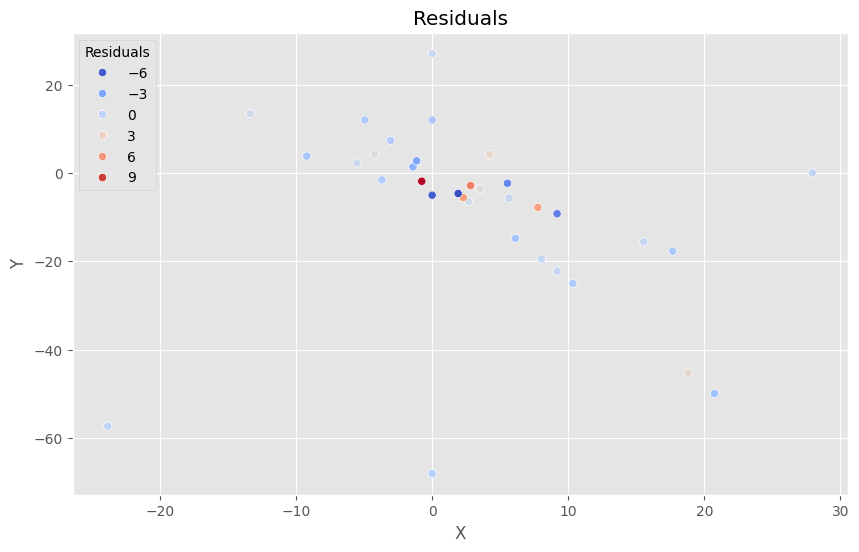

In [141]:
# plot the residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x='X_coord', y='Y_coord', data=coefficients_df, hue='Residuals', palette='coolwarm')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Residuals')
plt.show()

In [150]:
fcmap['Services'][1]

'Private Hospitals'